<a href="https://colab.research.google.com/github/huyhuy382003/Apple_stocks_predict/blob/main/Welcome_To_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 1) Install Java, Spark, Hadoop
!apt-get update -qq
!apt-get install -y openjdk-8-headless -qq
!wget -q https://archive.apache.org/dist/spark/spark-3.3.2/spark-3.3.2-bin-hadoop3.tgz
!tar xf spark-3.3.2-bin-hadoop3.tgz

# 2) Set environment variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.2-bin-hadoop3"

# 3) Install Python packages
!pip install -q pyspark yfinance findspark

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
E: Unable to locate package openjdk-8-headless


In [3]:
# ─ Install Java and Spark ──────────────────────────────────────
!apt-get update -qq
!apt-get install -y openjdk-8-jdk-headless -qq

# Download and unpack Spark
!wget -q https://archive.apache.org/dist/spark/spark-3.3.2/spark-3.3.2-bin-hadoop3.tgz
!tar xf spark-3.3.2-bin-hadoop3.tgz -C /usr/local
!mv /usr/local/spark-3.3.2-bin-hadoop3 /usr/local/spark

# ─ Set environment vars ────────────────────────────────────────
import os
os.environ["JAVA_HOME"]  = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/usr/local/spark"

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package libxtst6:amd64.
(Reading database ... 126102 files and directories currently installed.)
Preparing to unpack .../libxtst6_2%3a1.2.3-1build4_amd64.deb ...
Unpacking libxtst6:amd64 (2:1.2.3-1build4) ...
Selecting previously unselected package openjdk-8-jre-headless:amd64.
Preparing to unpack .../openjdk-8-jre-headless_8u452-ga~us1-0ubuntu1~22.04_amd64.deb ...
Unpacking openjdk-8-jre-headless:amd64 (8u452-ga~us1-0ubuntu1~22.04) ...
Selecting previously unselected package openjdk-8-jdk-headless:amd64.
Preparing to unpack .../openjdk-8-jdk-headless_8u452-ga~us1-0ubuntu1~22.04_amd64.deb ...
Unpacking openjdk-8-jdk-headless:amd64 (8u452-ga~us1-0ubuntu1~22.04) ...
Setting up libxtst6:amd64 (2:1.2.3-1build4) ...
Setting up openjdk-8-jre-headless:amd64 (8u452-ga~us1-0ubu

In [1]:
import os
# (re-export in case you restarted runtime)
os.environ["JAVA_HOME"]  = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/usr/local/spark"

import findspark
findspark.init()   # no args needed now that SPARK_HOME is set

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master("local[*]") \
    .appName("AAPL_Prediction_Colab") \
    .getOrCreate()

print("✅ SparkSession started:", spark)

✅ SparkSession started: <pyspark.sql.session.SparkSession object at 0x7f1f239429d0>


In [5]:
# 1) Download Apple data in pandas
import yfinance as yf
pdf = yf.download("AAPL",
                  start="2018-01-01",
                  progress=False,
                  group_by="column",
                  auto_adjust=False).reset_index()
# Make sure columns are flat and only the ones we need:
import pandas as pd
if isinstance(pdf.columns, pd.MultiIndex):
    pdf.columns = pdf.columns.get_level_values(0)
pdf = pdf[["Date","Open","High","Low","Close","Volume"]]

# 2) Write it out to a local CSV
csv_path = "/content/aapl.csv"
pdf.to_csv(csv_path, index=False)

# 3) Let Spark read the CSV (no Python‐object pickling at all!)
from pyspark.sql.functions import to_date
df = (spark.read
           .option("header","true")
           .option("inferSchema","true")
           .csv(csv_path)
           .withColumn("Date", to_date("Date","yyyy-MM-dd"))
           .orderBy("Date"))

# 4) Now continue with your feature‐engineering + modeling
from pyspark.sql.functions import lag, avg
from pyspark.sql.window import Window
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator

w = Window.orderBy("Date")
df = (df
      .withColumn("PrevClose", lag("Close",1).over(w))
      .withColumn("MA5",      avg("Close").over(w.rowsBetween(-5,-1)))
      .withColumn("MA10",     avg("Close").over(w.rowsBetween(-10,-1)))
      .na.drop())

assembler = VectorAssembler(
    inputCols=["Open","High","Low","Volume","PrevClose","MA5","MA10"],
    outputCol="features"
)
train_df, test_df = df.randomSplit([0.8,0.2], seed=42)

rf = RandomForestRegressor(
    labelCol="Close", featuresCol="features",
    numTrees=100, maxDepth=5, seed=42
)
model = Pipeline(stages=[assembler, rf]).fit(train_df)

preds = model.transform(test_df)
rmse = RegressionEvaluator(
    labelCol="Close", predictionCol="prediction",
    metricName="rmse"
).evaluate(preds)
print(f"AAPL Test RMSE: {rmse:.4f}")

preds.select("Date","Close","prediction") \
     .orderBy("Date") \
     .show(10,truncate=False)


AAPL Test RMSE: 3.1447
+----------+------------------+------------------+
|Date      |Close             |prediction        |
+----------+------------------+------------------+
|2018-01-05|43.75             |43.70016875504387 |
|2018-01-11|43.81999969482422 |43.731604847009194|
|2018-01-16|44.04750061035156 |43.987712890172396|
|2018-01-23|44.2599983215332  |43.987712890172396|
|2018-01-31|41.85749816894531 |40.10765680971549 |
|2018-02-06|40.75749969482422 |40.016806264201115|
|2018-02-14|41.842498779296875|40.016806264201115|
|2018-02-23|43.875            |43.9436841741815  |
|2018-03-09|44.994998931884766|43.987712890172396|
|2018-03-12|45.43000030517578 |43.987712890172396|
+----------+------------------+------------------+
only showing top 10 rows



In [6]:
from pyspark.ml.evaluation import RegressionEvaluator

# RMSE (you already have)
rmse_evaluator = RegressionEvaluator(
    labelCol="Close", predictionCol="prediction", metricName="rmse"
)
rmse = rmse_evaluator.evaluate(preds)

# MAE
mae_evaluator = RegressionEvaluator(
    labelCol="Close", predictionCol="prediction", metricName="mae"
)
mae = mae_evaluator.evaluate(preds)

# R²
r2_evaluator = RegressionEvaluator(
    labelCol="Close", predictionCol="prediction", metricName="r2"
)
r2 = r2_evaluator.evaluate(preds)

print(f"RMSE = {rmse:.4f}, MAE = {mae:.4f}, R² = {r2:.4f}")


RMSE = 3.1447, MAE = 2.0571, R² = 0.9973


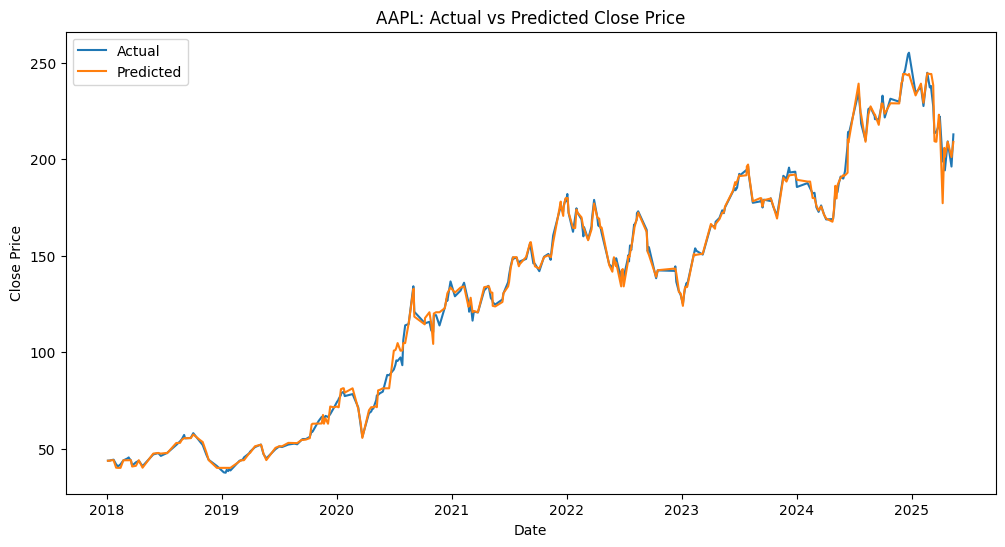

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) Bring Spark DataFrame into pandas
pdf = preds.select("Date", "Close", "prediction").toPandas()
pdf['Date'] = pd.to_datetime(pdf['Date'])
pdf.set_index('Date', inplace=True)

# 2) Plot
plt.figure(figsize=(12, 6))
plt.plot(pdf.index, pdf['Close'], label='Actual')
plt.plot(pdf.index, pdf['prediction'], label='Predicted')
plt.legend()
plt.title('AAPL: Actual vs Predicted Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()


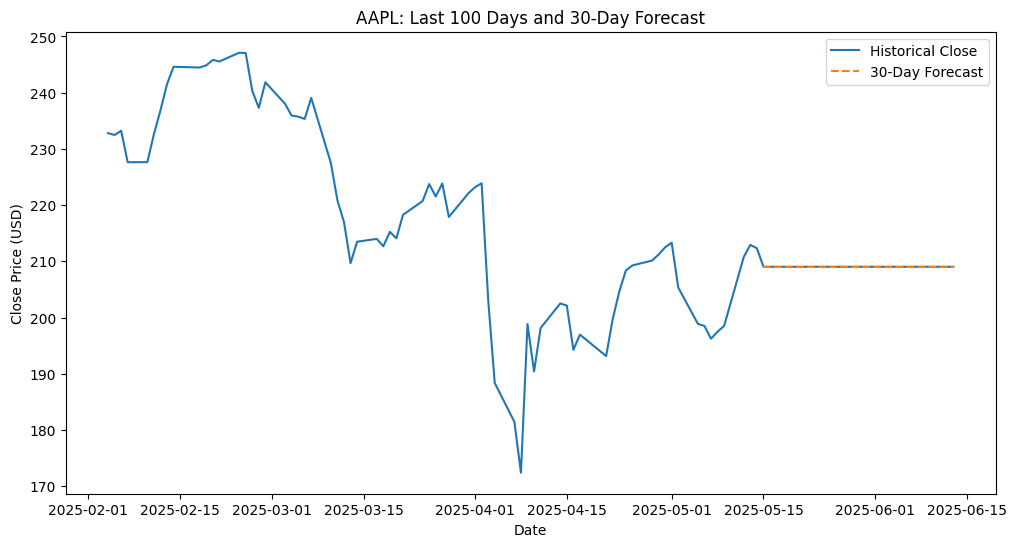

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta
from pyspark.ml.linalg import Vectors

# 1. Extract the trained RF model
rf_model = model.stages[-1]

# 2. Load full history into pandas
history_pdf = df.select("Date","Open","High","Low","Close","Volume") \
                .orderBy("Date") \
                .toPandas()
history_pdf['Date'] = pd.to_datetime(history_pdf['Date'])

# 3. Iteratively forecast next 30 days
future = []
for _ in range(30):
    last10 = history_pdf['Close'].iloc[-10:]
    next_date = history_pdf['Date'].iloc[-1] + timedelta(days=1)

    prev_close = last10.iloc[-1]
    ma5 = last10.iloc[-5:].mean()
    ma10 = last10.mean()
    last = history_pdf.iloc[-1]
    feat = [
        float(last['Open']), float(last['High']), float(last['Low']),
        float(last['Volume']), float(prev_close), float(ma5), float(ma10)
    ]
    vec = Vectors.dense(feat)

    # Local prediction
    pred = rf_model.predict(vec)
    future.append((next_date, pred))

    # Build a one-row DataFrame and concat
    new_row = pd.DataFrame([{
        'Date':   next_date,
        'Open':   feat[0],
        'High':   feat[1],
        'Low':    feat[2],
        'Close':  pred,
        'Volume': feat[3]
    }])
    history_pdf = pd.concat([history_pdf, new_row], ignore_index=True)

# 4. Plot last 100 days + 30-day forecast
history_pdf.set_index('Date', inplace=True)
hist_series = history_pdf['Close']

future_df = pd.DataFrame(future, columns=['Date','Forecast']).set_index('Date')

plt.figure(figsize=(12,6))
plt.plot(hist_series[-100:], label='Historical Close')
plt.plot(future_df.index, future_df['Forecast'], '--', label='30-Day Forecast')
plt.title('AAPL: Last 100 Days and 30-Day Forecast')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.legend()
plt.show()
